# Refugee Inflow and Crime Rates in Germany

This notebook reproduces the full Difference-in-Differences analysis for the project:

- construct a regional panel for 2010–2020
- define treatment intensity and treated vs. control regions
- estimate baseline and two-way fixed effects DiD models
- run pre-trend, placebo and different threshold checks
- estimate an event-study model
- visualize dynamic treatment effects

## 1. Setup

Import project modules and configure paths.

In [1]:
from pathlib import Path
import sys

import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

# To make sure src/ is on sys.path so we can import refugees_did
SRC_DIR = Path.cwd().parents[0] / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from refugees_did.config import PANEL_PATH
from refugees_did.design import prepare_analysis_panel
from refugees_did import models as md
from refugees_did import plots as pl

## 2. Load and prepare the panel data

Load the processed panel and apply the design layer:

- ensure crime rate is present
- compute treatment intensity
- define treated vs. control regions
- add `treated`, `post`, and `did` indicators

In [2]:
panel = pd.read_csv(PANEL_PATH)
print(panel.shape)
panel.head()

(176, 35)


,year,region,total_cases,crime_rate_per_100k,cleared_cases,clearance_rate_pct,total_suspects,non_german_abs,non_german_pct,Afghanistan_foreigners,...,Pakistan_protection,Somalia_protection,Syrian_protection,Turkey_protection,Yemen_protection,Foreigners,Germans,population_total,foreigners_share_pct,ilo_unemployment_rate_pct
0,2010,Baden-Wurttemberg,572049,5324.0,342624,59.9,230283,65778,28.563984,2838.0,...,1180.0,285.0,1135.0,8960.0,0.0,1270827,9477623,10748450,13.408710,4.9
1,2011,Baden-Wurttemberg,582844,5420.0,341764,58.6,228558,67579,29.567550,3268.0,...,1685.0,260.0,1150.0,8735.0,0.0,1137197,9358277,10495474,12.151778,4.0
2,2012,Baden-Wurttemberg,573459,5317.0,330965,57.7,229382,70699,30.821512,3571.0,...,2475.0,195.0,1755.0,8600.0,0.0,1180279,9360498,10540777,12.609148,3.9
3,2013,Baden-Wurttemberg,576067,5450.5,333922,58.0,231635,75870,32.800000,4168.0,...,3270.0,195.0,3045.0,8440.0,0.0,1237300,9362896,10600196,13.214928,4.1
4,2014,Baden-Wurttemberg,594534,5592.3,349922,58.9,243361,86974,35.700000,4653.0,...,3765.0,535.0,6625.0,8180.0,0.0,1307480,9366482,10673962,13.959136,4.0


In [3]:
# Apply DiD design to the panel data
panel = prepare_analysis_panel(panel)
panel.head()

,year,region,total_cases,crime_rate_per_100k,cleared_cases,clearance_rate_pct,total_suspects,non_german_abs,non_german_pct,Afghanistan_foreigners,...,Yemen_protection,Foreigners,Germans,population_total,foreigners_share_pct,ilo_unemployment_rate_pct,treatment_intensity,treated,post,did
0,2010,Baden-Wurttemberg,572049,5324.0,342624,59.9,230283,65778,28.563984,2838.0,...,0.0,1270827,9477623,10748450,13.408710,4.9,NaN,1,0,0
1,2011,Baden-Wurttemberg,582844,5420.0,341764,58.6,228558,67579,29.567550,3268.0,...,0.0,1137197,9358277,10495474,12.151778,4.0,-1214.0,1,0,0
2,2012,Baden-Wurttemberg,573459,5317.0,330965,57.7,229382,70699,30.821512,3571.0,...,0.0,1180279,9360498,10540777,12.609148,3.9,-1898.0,1,0,0
3,2013,Baden-Wurttemberg,576067,5450.5,333922,58.0,231635,75870,32.800000,4168.0,...,0.0,1237300,9362896,10600196,13.214928,4.1,-400.0,1,0,0
4,2014,Baden-Wurttemberg,594534,5592.3,349922,58.9,243361,86974,35.700000,4653.0,...,0.0,1307480,9366482,10673962,13.959136,4.0,5565.0,1,0,0


In [4]:
panel.describe()

,year,total_cases,crime_rate_per_100k,cleared_cases,clearance_rate_pct,total_suspects,non_german_abs,non_german_pct,Afghanistan_foreigners,Eritrea_foreigners,...,Yemen_protection,Foreigners,Germans,population_total,foreigners_share_pct,ilo_unemployment_rate_pct,treatment_intensity,treated,post,did
count,176.0000,1.760000e+02,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,...,176.000000,1.760000e+02,1.760000e+02,1.760000e+02,176.000000,176.000000,160.000000,176.000000,176.000000,176.000000
mean,2015.0000,3.677968e+05,8096.075507,206334.437500,56.341071,137986.789773,43469.312500,28.368001,9885.988636,2536.346591,...,72.017045,5.175572e+05,4.595729e+06,5.113287e+06,10.107249,7.371591,8160.756250,0.500000,0.454545,0.227273
std,3.1713,3.281895e+05,2766.368047,176009.528147,6.745963,120020.256796,47286.273269,11.651650,10964.728432,3766.194657,...,236.590169,6.046948e+05,4.148923e+06,4.718026e+06,5.938467,2.504531,17783.432188,0.501427,0.499350,0.420266
min,2010.0000,6.840000e+04,4524.993794,36639.000000,42.036705,24095.000000,3256.000000,6.019947,138.000000,0.000000,...,0.000000,2.750200e+04,5.528360e+05,6.518260e+05,1.556051,2.800000,-6472.000000,0.000000,0.000000,0.000000
25%,2012.0000,1.595122e+05,6552.775000,95071.250000,51.150000,61555.500000,10398.000000,18.975000,1503.250000,92.000000,...,0.000000,9.309850e+04,1.912556e+06,2.057573e+06,4.795660,5.500000,587.750000,0.000000,0.000000,0.000000
50%,2015.0000,2.407635e+05,7126.869681,132492.000000,56.750000,89444.500000,25472.000000,28.531992,6059.000000,995.000000,...,0.000000,2.291305e+05,2.804268e+06,3.104750e+06,9.907752,7.100000,2469.500000,0.500000,0.000000,0.000000
75%,2018.0000,5.218578e+05,8191.232241,273412.750000,62.225000,184987.500000,61436.000000,36.915812,12976.250000,2913.750000,...,5.000000,7.154990e+05,5.845445e+06,6.662099e+06,14.581526,8.850000,8145.000000,1.000000,1.000000,0.000000
max,2020.0000,1.518369e+06,16414.258949,753023.000000,72.500000,494955.000000,281500.000000,61.000000,43565.000000,17020.000000,...,1560.000000,2.463137e+06,1.598128e+07,1.793994e+07,24.090084,13.600000,156703.000000,1.000000,1.000000,1.000000


## 3. Descriptive analysis

First need to inspect if the data is valid for DiD analysis, we will check:

- the distribution of treatment intensity in 2016
- parallel trends in crime rates for treated vs. control regions

<Axes: title={'center': 'Treatment intensity by region in 2016'}, xlabel='Treatment intensity', ylabel='Region'>

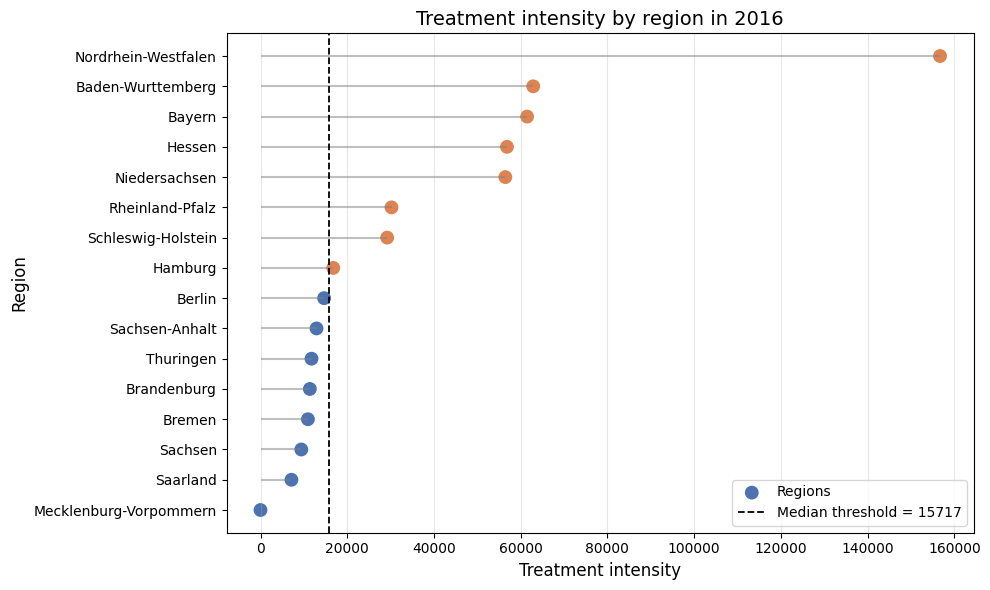

In [5]:
# Distribution of treatment intensity used to define treated regions
pl.plot_treatment_intensity(panel, year=2016)

**Interpretation:**  
The distribution shows a clear separation between low-inflow and high-inflow regions in 2016.  
Most treated regions cluster between 20 000 and 70 000, while one region shows a much larger inflow (~150 000), forming a long right tail.  
Despite this outlier, the median threshold provides a stable split into treated vs. control groups.

<Axes: title={'center': 'Parallel trends: treated vs control'}, xlabel='Year', ylabel='crime_rate_per_100k'>

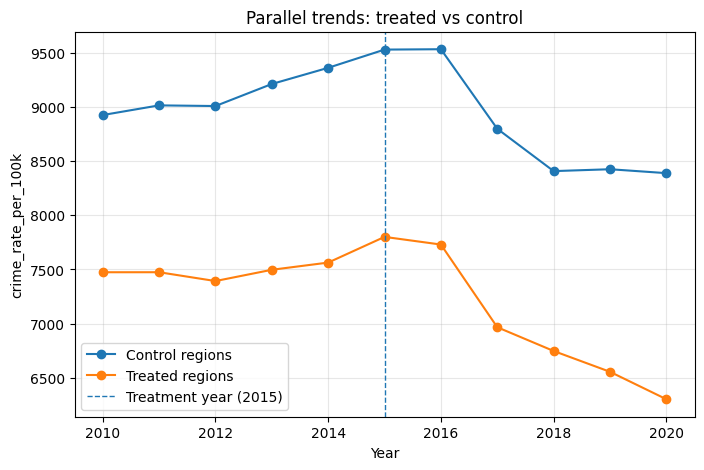

In [6]:
# Parallel trends in crime rates for treated vs. control regions
pl.plot_parallel_trends(panel, outcome="crime_rate_per_100k")

**Interpretation:**  
Before 2015, crime rates in treated and control regions move in roughly parallel trajectories.  
This **visual pattern supports the parallel trends assumption** required for valid DiD identification.

## 4. Difference-in-Differences models

We estimate:

1. A simple baseline DiD with only the `did` indicator.  
2. A two-way fixed effects model with region and year FE and HC3 robust errors.

In [7]:
# 4.1 Baseline DID model
baseline_model = md.fit_baseline_did(panel)
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.059
Model:                             OLS   Adj. R-squared:                  0.054
Method:                  Least Squares   F-statistic:                     14.23
Date:                 Sat, 06 Dec 2025   Prob (F-statistic):           0.000222
Time:                         23:46:06   Log-Likelihood:                -1638.7
No. Observations:                  176   AIC:                             3281.
Df Residuals:                      174   BIC:                             3288.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8459.4445    243.070     34.803      0.000    7983.036    8935.853
did        -1598.8238    423.897     -3.772      0.000   -2429.646    -768.002
==============================================================================
Omnibus:                       39.904   Durbin-Watson:                   0.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.936
Skew:                           1.369   Prob(JB):                     1.59e-13
Kurtosis:                       3.737   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [8]:
# 4.2 Two-way fixed effects DID model
main_model = md.fit_main_did(panel)
main_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.980
Model:                             OLS   Adj. R-squared:                  0.977
Method:                  Least Squares   F-statistic:                     165.7
Date:                 Sat, 06 Dec 2025   Prob (F-statistic):           1.21e-96
Time:                         23:46:06   Log-Likelihood:                -1299.2
No. Observations:                  176   AIC:                             2652.
Df Residuals:                      149   BIC:                             2738.
Df Model:                           26                                         
Covariance Type:                   HC3                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            5512.9721    157.499     35.003      0.000    5204.280    5821.664
C(region)[T.Bayern]                  -156.9623    200.129     -0.784      0.433    -549.209     235.284
C(region)[T.Berlin]                  9278.9292    266.269     34.848      0.000    8757.051    9800.807
C(region)[T.Brandenburg]             2019.5841    169.403     11.922      0.000    1687.560    2351.608
C(region)[T.Bremen]                  7288.3796    266.315     27.368      0.000    6766.413    7810.347
C(region)[T.Hamburg]                 7336.4953    195.251     37.575      0.000    6953.810    7719.180
C(region)[T.Hessen]                   931.1560    111.873      8.323      0.000     711.890    1150.422
C(region)[T.Mecklenburg-Vorpommern]  1843.9388    162.143     11.372      0.000    1526.145    2161.733
C(region)[T.Niedersachsen]           1489.8551    114.541     13.007      0.000    1265.359    1714.351
C(region)[T.Nordrhein-Westfalen]     2578.6584    134.299     19.201      0.000    2315.437    2841.879
C(region)[T.Rheinland-Pfalz]         1107.7062    115.980      9.551      0.000     880.390    1335.022
C(region)[T.Saarland]                1845.2835    164.762     11.200      0.000    1522.357    2168.210
C(region)[T.Sachsen]                 1929.4549    156.538     12.326      0.000    1622.646    2236.264
C(region)[T.Sachsen-Anhalt]          2849.3897    138.941     20.508      0.000    2577.070    3121.709
C(region)[T.Schleswig-Holstein]      1644.2731    155.384     10.582      0.000    1339.727    1948.820
C(region)[T.Thuringen]               1006.3044    183.257      5.491      0.000     647.127    1365.482
C(year)[T.2011]                        44.7500    197.625      0.226      0.821    -342.588     432.088
C(year)[T.2012]                         0.9375    163.900      0.006      0.995    -320.300     322.175
C(year)[T.2013]                       154.6562    159.439      0.970      0.332    -157.839     467.151
C(year)[T.2014]                       262.6062    173.106      1.517      0.129     -76.675     601.887
C(year)[T.2015]                       465.2242    192.315      2.419      0.016      88.294     842.155
C(year)[T.2016]                       536.0636    206.992      2.590      0.010     130.367     941.760
C(year)[T.2017]                      -212.6964    191.279     -1.112      0.266    -587.597     162.204
C(year)[T.2018]                      -517.6363    215.564     -2.401      0.016    -940.134     -95.139
C(year)[T.2019]                      -605.0602    199.686     -3.030      0.002    -996.437    -213.684
C(year)[T.2020]                      -749.6127    204.155     -3.672      0.000   -1149.749    -349.476
did                                  -208.9607    138.69

In [9]:
# 4.3 DID with covariates (robustness check)
cov_model = md.fit_did_with_covariates(panel)
cov_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.981
Model:                             OLS   Adj. R-squared:                  0.977
Method:                  Least Squares   F-statistic:                     164.1
Date:                 Sat, 06 Dec 2025   Prob (F-statistic):           8.21e-97
Time:                         23:46:06   Log-Likelihood:                -1297.6
No. Observations:                  176   AIC:                             2653.
Df Residuals:                      147   BIC:                             2745.
Df Model:                           28                                         
Covariance Type:                   HC3                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            6438.8496    817.124      7.880      0.000    4837.315    8040.384
C(region)[T.Bayern]                  -338.0145    288.179     -1.173      0.241    -902.835     226.806
C(region)[T.Berlin]                  9676.6677    645.559     14.990      0.000    8411.395    1.09e+04
C(region)[T.Brandenburg]             1527.3650   1153.591      1.324      0.185    -733.632    3788.362
C(region)[T.Bremen]                  7646.5310    710.603     10.761      0.000    6253.774    9039.288
C(region)[T.Hamburg]                 7535.3017    331.335     22.742      0.000    6885.898    8184.706
C(region)[T.Hessen]                  1011.2384    179.744      5.626      0.000     658.947    1363.530
C(region)[T.Mecklenburg-Vorpommern]  1395.7593   1288.365      1.083      0.279   -1129.390    3920.908
C(region)[T.Niedersachsen]           1158.1249    648.939      1.785      0.074    -113.772    2430.022
C(region)[T.Nordrhein-Westfalen]     2555.8040    502.048      5.091      0.000    1571.809    3539.799
C(region)[T.Rheinland-Pfalz]          843.8240    460.071      1.834      0.067     -57.898    1745.546
C(region)[T.Saarland]                1665.7851    637.616      2.613      0.009     416.081    2915.489
C(region)[T.Sachsen]                 1439.6139   1114.573      1.292      0.196    -744.909    3624.137
C(region)[T.Sachsen-Anhalt]          2403.0717   1246.666      1.928      0.054     -40.350    4846.493
C(region)[T.Schleswig-Holstein]      1233.4904    776.220      1.589      0.112    -287.873    2754.854
C(region)[T.Thuringen]                474.3638   1057.615      0.449      0.654   -1598.524    2547.252
C(year)[T.2011]                       -36.2712    200.334     -0.181      0.856    -428.918     356.376
C(year)[T.2012]                       -70.7051    181.355     -0.390      0.697    -426.155     284.745
C(year)[T.2013]                       104.8530    169.757      0.618      0.537    -227.866     437.571
C(year)[T.2014]                       237.5982    196.206      1.211      0.226    -146.958     622.155
C(year)[T.2015]                       489.5067    256.518      1.908      0.056     -13.260     992.273
C(year)[T.2016]                       579.7515    379.181      1.529      0.126    -163.429    1322.932
C(year)[T.2017]                      -143.0336    457.408     -0.313      0.755   -1039.536     753.469
C(year)[T.2018]                      -430.9569    534.072     -0.807      0.420   -1477.719     615.805
C(year)[T.2019]                      -499.2346    603.244     -0.828      0.408   -1681.571     683.102
C(year)[T.2020]                      -593.7442    550.579     -1.078      0.281   -1672.860     485.372
did                                  -141.3268    208.59

## 5. Diagnostics: pre-trends, placebo and different threshold test

Three additional checks:

- **Pre-trend model**: interaction of `treated` with time trend on pre-2015 data.
- **Placebo DiD**: fake treatment before the actual refugee shock.
- **Different threshold**: method to show that there is no significantly different results with differt threshold (avoid particular choice bias)

In [10]:
# 5.1 Pre-trend test (2010–2014 only)
pretrend_model = md.fit_pretrend_interaction(panel)
pretrend_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.985
Model:                             OLS   Adj. R-squared:                  0.982
Method:                  Least Squares   F-statistic:                     6585.
Date:                 Sat, 06 Dec 2025   Prob (F-statistic):          2.50e-116
Time:                         23:46:06   Log-Likelihood:                -696.86
No. Observations:                   96   AIC:                             1430.
Df Residuals:                       78   BIC:                             1476.
Df Model:                           17                                         
Covariance Type:                   HC3                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            7630.0474    106.275     71.796      0.000    7421.753    7838.342
C(region)[T.Bayern]                  -228.9337    224.892     -1.018      0.309    -669.714     211.846
C(region)[T.Berlin]                  6969.2499    342.590     20.343      0.000    6297.786    7640.714
C(region)[T.Brandenburg]               -7.0542    162.883     -0.043      0.965    -326.299     312.191
C(region)[T.Bremen]                  5441.2995    254.862     21.350      0.000    4941.780    5940.819
C(region)[T.Hamburg]                 7762.3425    228.721     33.938      0.000    7314.057    8210.628
C(region)[T.Hessen]                  1068.3439     75.002     14.244      0.000     921.343    1215.345
C(region)[T.Mecklenburg-Vorpommern]  -338.5327    203.773     -1.661      0.097    -737.920      60.855
C(region)[T.Niedersachsen]           1645.0955     96.757     17.002      0.000    1455.454    1834.737
C(region)[T.Nordrhein-Westfalen]     2965.5892     70.701     41.946      0.000    2827.018    3104.160
C(region)[T.Rheinland-Pfalz]         1300.2382    107.565     12.088      0.000    1089.416    1511.061
C(region)[T.Saarland]                -626.1153    106.541     -5.877      0.000    -834.931    -417.299
C(region)[T.Sachsen]                 -405.9374    120.965     -3.356      0.001    -643.024    -168.851
C(region)[T.Sachsen-Anhalt]           460.0363     92.406      4.978      0.000     278.924     641.148
C(region)[T.Schleswig-Holstein]      1940.3749    195.935      9.903      0.000    1556.349    2324.401
C(region)[T.Thuringen]              -1567.2184     78.482    -19.969      0.000   -1721.041   -1413.396
treated                             -2295.6804    136.809    -16.780      0.000   -2563.822   -2027.539
year_num                              121.8250     49.347      2.469      0.014      25.107     218.543
treated:year_num                      -64.5981     60.835     -1.062      0.288    -183.832      54.636
==============================================================================
Omnibus:                       11.807   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.486
Skew:                           0.602   Prob(JB):                     0.000434
Kurtosis:                       4.556   Cond. No.                     3.61e+16
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 9.56e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [11]:
# 5.2 Placebo DID (fake treatment before 2015)
placebo_model = md.fit_placebo_did(panel)
placebo_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.980
Model:                             OLS   Adj. R-squared:                  0.977
Method:                  Least Squares   F-statistic:                     180.0
Date:                 Sat, 06 Dec 2025   Prob (F-statistic):           3.28e-99
Time:                         23:46:06   Log-Likelihood:                -1298.6
No. Observations:                  176   AIC:                             2651.
Df Residuals:                      149   BIC:                             2737.
Df Model:                           26                                         
Covariance Type:                   HC3                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            5565.8731    157.524     35.334      0.000    5257.132    5874.614
C(region)[T.Bayern]                  -156.9623    199.217     -0.788      0.431    -547.421     233.496
C(region)[T.Berlin]                  9173.1272    270.710     33.885      0.000    8642.545    9703.709
C(region)[T.Brandenburg]             1913.7821    206.277      9.278      0.000    1509.487    2318.077
C(region)[T.Bremen]                  7182.5777    307.295     23.374      0.000    6580.290    7784.866
C(region)[T.Hamburg]                 7336.4953    205.882     35.635      0.000    6932.975    7740.016
C(region)[T.Hessen]                   931.1560    102.261      9.106      0.000     730.729    1131.583
C(region)[T.Mecklenburg-Vorpommern]  1738.1369    204.957      8.480      0.000    1336.428    2139.845
C(region)[T.Niedersachsen]           1489.8551    106.192     14.030      0.000    1281.722    1697.988
C(region)[T.Nordrhein-Westfalen]     2578.6584    134.799     19.130      0.000    2314.458    2842.859
C(region)[T.Rheinland-Pfalz]         1107.7062    105.725     10.477      0.000     900.489    1314.923
C(region)[T.Saarland]                1739.4815    196.403      8.857      0.000    1354.538    2124.425
C(region)[T.Sachsen]                 1823.6529    185.542      9.829      0.000    1459.998    2187.308
C(region)[T.Sachsen-Anhalt]          2743.5877    172.212     15.931      0.000    2406.058    3081.118
C(region)[T.Schleswig-Holstein]      1644.2731    143.609     11.450      0.000    1362.804    1925.742
C(region)[T.Thuringen]                900.5024    210.660      4.275      0.000     487.616    1313.389
C(year)[T.2011]                        44.7500    197.882      0.226      0.821    -343.092     432.592
C(year)[T.2012]                         0.9375    164.363      0.006      0.995    -321.208     323.083
C(year)[T.2013]                       292.6953    193.211      1.515      0.130     -85.991     671.382
C(year)[T.2014]                       400.6453    206.133      1.944      0.052      -3.368     804.658
C(year)[T.2015]                       603.2632    226.378      2.665      0.008     159.571    1046.956
C(year)[T.2016]                       569.6224    218.833      2.603      0.009     140.719     998.526
C(year)[T.2017]                      -179.1377    201.297     -0.890      0.374    -573.672     215.396
C(year)[T.2018]                      -484.0775    222.068     -2.180      0.029    -919.324     -48.832
C(year)[T.2019]                      -571.5015    210.654     -2.713      0.007    -984.376    -158.627
C(year)[T.2020]                      -716.0539    215.918     -3.316      0.001   -1139.245    -292.863
fake_did                             -276.0781    164.18

In [12]:
# 5.3 Different Thresholds

# Compute treatment_intensity distribution in 2016
ti_2016 = (
    panel.loc[panel["year"] == 2016, "treatment_intensity"]
    .dropna()
)

thresholds = {
    "p40": np.percentile(ti_2016, 40),
    "p60": np.percentile(ti_2016, 60),
    "p75": np.percentile(ti_2016, 75),
    "mean": ti_2016.mean(),
    "median": ti_2016.median(),  # baseline split
}

grid_results = md.run_threshold_grid(panel, thresholds)
grid_results

,name,threshold,coef_did_alt,se_did_alt,pvalue_did_alt
0,p40,12918.0000,-161.864290,142.657922,0.256529
1,p60,29203.0000,33.167456,129.450015,0.797782
2,p75,56552.7500,87.136668,142.634120,0.541259
3,mean,34295.5625,68.047942,131.907076,0.605940
4,median,15717.0000,-208.960698,138.692703,0.131902


## 6. Event-study model

We estimate dynamic treatment effects with leads and lags around 2015:

- extract event-study coefficients
- construct a clean event-study table
- visualize the dynamic pattern with 95% confidence intervals

In [19]:
event_model = md.fit_event_study(panel, ref_year=2015)
event_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.981
Model:                             OLS   Adj. R-squared:                  0.976
Method:                  Least Squares   F-statistic:                     3675.
Date:                 Sat, 06 Dec 2025   Prob (F-statistic):          2.35e-191
Time:                         23:49:14   Log-Likelihood:                -1296.8
No. Observations:                  176   AIC:                             2666.
Df Residuals:                      140   BIC:                             2780.
Df Model:                           35                                         
Covariance Type:                   HC3                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                         7071.6252    220.036     32.139      0.000    6640.364    7502.887
C(region)[T.Bayern]                               -156.9623    215.683     -0.728      0.467    -579.694     265.769
C(region)[T.Berlin]                               8229.2010    233.886     35.185      0.000    7770.793    8687.609
C(region)[T.Brandenburg]                           969.8559    151.204      6.414      0.000     673.502    1266.209
C(region)[T.Bremen]                               6238.6515    259.241     24.065      0.000    5730.548    6746.755
C(region)[T.Hamburg]                              7336.4953    212.068     34.595      0.000    6920.849    7752.142
C(region)[T.Hessen]                                931.1560    115.629      8.053      0.000     704.527    1157.785
C(region)[T.Mecklenburg-Vorpommern]                794.2106    141.569      5.610      0.000     516.741    1071.680
C(region)[T.Niedersachsen]                        1489.8551    122.674     12.145      0.000    1249.419    1730.291
C(region)[T.Nordrhein-Westfalen]                  2578.6584    145.384     17.737      0.000    2293.712    2863.605
C(region)[T.Rheinland-Pfalz]                      1107.7062    118.759      9.327      0.000     874.943    1340.469
C(region)[T.Saarland]                              795.5553    137.476      5.787      0.000     526.108    1065.002
C(region)[T.Sachsen]                               879.7267    122.230      7.197      0.000     640.160    1119.293
C(region)[T.Sachsen-Anhalt]                       1799.6615     96.027     18.741      0.000    1611.451    1987.872
C(region)[T.Schleswig-Holstein]                   1644.2731    155.956     10.543      0.000    1338.605    1949.942
C(region)[T.Thuringen]                             -43.4238    165.796     -0.262      0.793    -368.378     281.531
C(year, Treatment(reference=2015))[T.2010]        -604.0551    342.342     -1.764      0.078   -1275.033      66.923
C(year, Treatment(reference=2015))[T.2011]        -514.8051    356.232     -1.445      0.148   -1213.008     183.398
C(year, Treatment(reference=2015))[T.2012]        -520.9301    276.053     -1.887      0.059   -1061.984      20.124
C(year, Treatment(reference=2015))[T.2013]        -317.5051    244.478     -1.299      0.194    -796.672     161.662
C(year, Treatment(reference=2015))[T.2014]        -168.0801    283.910     -0.592      0.554    -724.534     388.374
C(year, Treatment(reference=2015))[T.2016]           3.4444    294.645      0.012      0.991    -574.050     580.938
C(year, Treatment(reference=2015))[T.2017]        -730.9216    289.790     -2.522      0.012   -1298.900    -162.943
C(year, Treatment(reference=20

<Axes: title={'center': 'Event-study: dynamic treatment effects'}, xlabel='Years relative to 2015', ylabel='Effect on crime_rate_per_100k'>

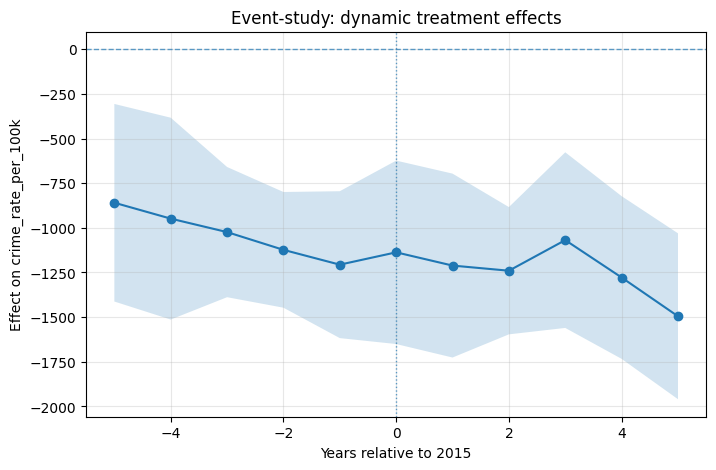

In [14]:
pl.plot_event_study(event_model, ref_year=2015)

**Interpretation:**  
Pre-treatment coefficients are negative but stable across years, indicating a stable baseline level difference.
After 2015, the coefficients remain at a similar negative trend, and the pattern does not change, showing **no structural break** following the refugee inflow.  
Confidence intervals do not cross zero, but the overall shape of the curve confirms that **there is no dynamic treatment effect** over time.

## 7. Save key figures (optional)

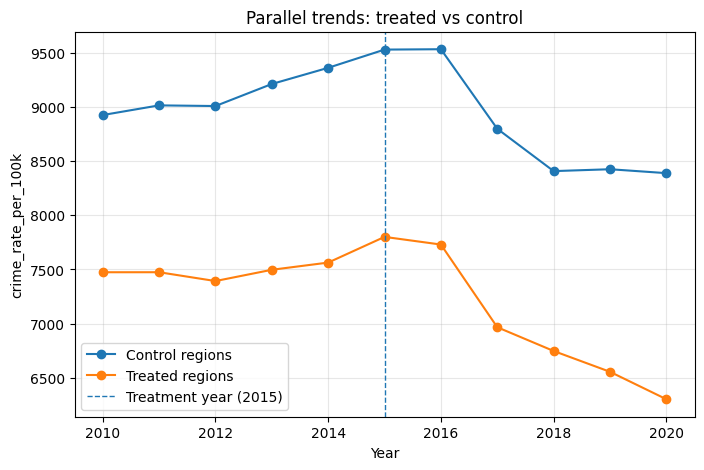

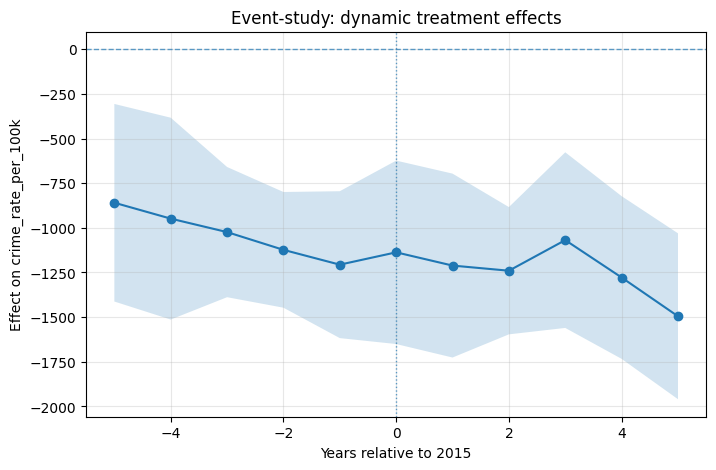

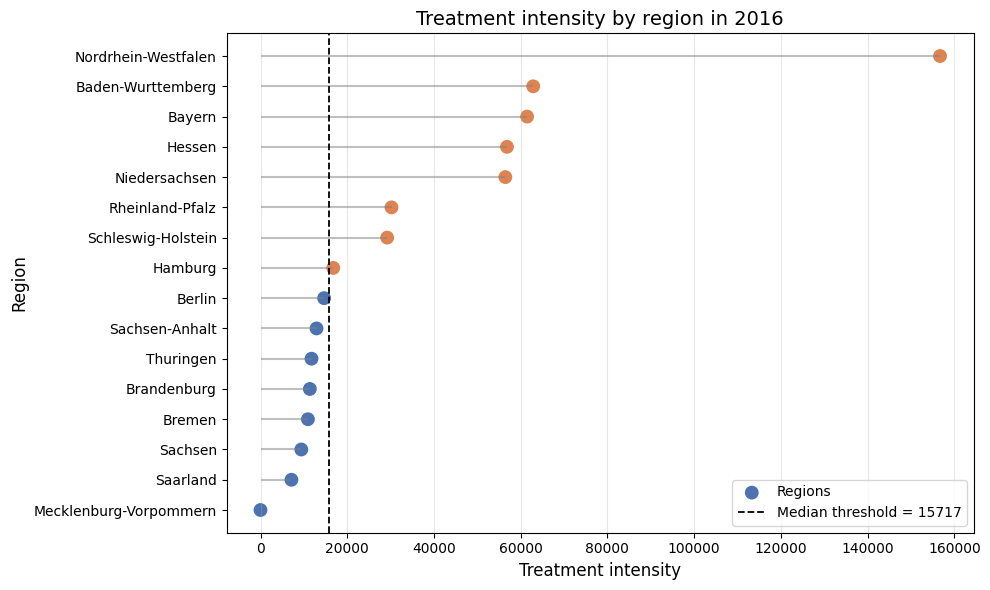

In [15]:
figures_dir = Path.cwd().parents[0] / "figures"
figures_dir.mkdir(exist_ok=True)

# Parallel trends
ax = pl.plot_parallel_trends(panel, outcome="crime_rate_per_100k")
ax.figure.savefig(figures_dir / "parallel_trends.png", bbox_inches="tight")

# Event study
ax = pl.plot_event_study(event_model, ref_year=2015)
ax.figure.savefig(figures_dir / "event_study.png", bbox_inches="tight")

# Treatment intensity
ax = pl.plot_treatment_intensity(panel, year=2016)
ax.figure.savefig(figures_dir / "treatment_intensity_2016.png", bbox_inches="tight")

## 8. Summary

- The baseline DID shows a negative association between treatment and crime,  
  but it is not causal without fixed effects.
- The two-way FE model finds **no statistically significant effect** of refugee inflows on crime.
- Adding unemployment and demographic composition does not alter the conclusion: **the refugee inflow did not causally increase crime rates in German regions**
- Pre-trend and placebo tests show no evidence of spurious effects or pre-treatment divergence.
- Treatment assignment is **not artificially creating** the DID effect 
- Event-study pattern supports the DiD findings: although treated regions have a lower baseline crime rate, the **trend does not shift after 2015**, implying **no dynamic causal impact** of refugee inflow on crime.

Overall, the analysis finds **no causal evidence** that the 2015 refugee inflow increased crime rates in German regions.